In [1]:
!pip install uszipcode
import os
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import model_from_json, load_model

warnings.filterwarnings('ignore')
NUM_SAMPLES = 5

  Using cached uszipcode-0.2.6-py2.py3-none-any.whl (454 kB)
  Using cached pathlib_mate-1.0.1-py2.py3-none-any.whl (78 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
def load_data(_input_dir, _output_dir="output", _data_size=-1):
    """
    :param _input_dir: input directory name
                      AWS S3 directory name, where the input files are stored
    :param _output_dir: output directory name
                      AWS S3 directory name, where the output files are saved
    :param _data_size: size of data
                      Data size, that needs to be tested, by default it takes value of
                      -1, which means consider all the data
    :return:
            the processed data, and demand data
    """
    import os.path
    import pandas as pd
    from pandas import DataFrame
    from uszipcode import SearchEngine

    # to obtain the zip-codes for latitude, longitude values
    engine = SearchEngine()

    # load all the data
    months = ["apr", "may", "jun", "jul", "aug", "sep"]
    file_format = "uber-raw-data-{}14.csv"
    _data = DataFrame()
    for month in months:
        file_name = _input_dir + "/" + file_format.format(month)
        df_sub = pd.read_csv(file_name)
        _data = _data.append(df_sub)

    # sample the data
    if _data_size > 0:
        _data = _data.sample(n=_data_size)

    # process date and time
    _data['Date/Time'] = pd.to_datetime(_data['Date/Time'], format='%m/%d/%Y %H:%M:%S')
    _data['month'] = _data['Date/Time'].dt.month
    _data['weekday'] = _data['Date/Time'].dt.dayofweek
    _data['day'] = _data['Date/Time'].dt.day
    _data['hour'] = _data['Date/Time'].dt.hour
    _data['minute'] = _data['Date/Time'].dt.minute
    _data['lat_short'] = round(_data['Lat'], 2)
    _data['lon_short'] = round(_data['Lon'], 2)

    # obtaining the zip-codes
    _data['zip'] = _data.apply(
        lambda row: engine.by_coordinates(row['Lat'], row['Lon'], radius=10)[0].zipcode, axis=1
    )

    # summarizing demand data
    _demand = (_data.groupby(['zip']).count()['Date/Time']).reset_index()
    _demand.columns = ['Zip', 'Number of Trips']
    _demand.to_csv(_output_dir + "/demand.csv", index=False)

    _demand_w = (_data.groupby(['zip', 'weekday']).count()['Date/Time']).reset_index()
    _demand_w.columns = ['Zip', 'Weekday', 'Number of Trips']
    _demand_w.to_csv(_output_dir + "/demand_dow.csv", index=False)

    _demand_h = (_data.groupby(['zip', 'hour']).count()['Date/Time']).reset_index()
    _demand_h.columns = ['Zip', 'Hour', 'Number of Trips']
    _demand_h.to_csv(_output_dir + "/demand_h.csv", index=False)

    _demand_wh = (_data.groupby(['zip', 'weekday', 'hour']).count()['Date/Time']).reset_index()
    _demand_wh.columns = ['Zip', 'Weekday', 'Hour', 'Number of Trips']
    _demand_wh.to_csv(_output_dir + "/demand_h_dow.csv", index=False)

    return _data, _demand, _demand_w, _demand_h, _demand_wh

In [7]:
class DemandPredictorBase(object):
    """
        Base class for demand predictor
    """

    def __init__(self, _x, _y, train=True, output_dir="."):
        self.x = _x
        self.y = _y
        self.output_dir = output_dir
        self.model = self.build_model()
        if train:
            self.train()

    def build_model(self):
        raise NotImplementedError

    def train(self):
        raise NotImplementedError

    def predict(self, _x_test):
        """
        :param _x_test: test dataset
        :return: prediction for the given test dataset _x_test
        """
        return self.model.predict(_x_test)

    def predict_and_scale(self, _x_test, _y_scalar):
        """
        :param _x_test: test dataset
        :param _y_scalar: Scaler
        :return: prediction for the given test dataset _x_test, scaled to the scalar
        """
        return _y_scalar.inverse_transform(self.predict(_x_test))

    @staticmethod
    def get_mse(_y_test, _y_pred):
        """
        :param _y_test: actual test values
        :param _y_pred: predicted test values
        :return: return the mean square error
        """
        return mean_squared_error(_y_test, _y_pred)


class DemandPredictorNN(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir=".", hidden_layer_conf=None, d_key="", dt_size=-1):
        self.input_shape = len(_x[0])
        self.output_shape = len(_y[0])
        self.hidden_layer_conf = hidden_layer_conf
        self.d_key = d_key
        self.dt_size = dt_size
        self.epochs = 4000
        self.batch_size = 150
        self.verbose = 0
        self.validation_split = 0.2
        self.learning_rate = 0.01
        self.history = None
        super(DemandPredictorNN, self).__init__(_x, _y, train, output_dir)

    def build_model(self):
        """
            build the model
        """

        model = Sequential()
        model.add(InputLayer(input_shape=(self.input_shape,)))
        if self.hidden_layer_conf is None:
            model.add(Dense(168, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(24, activation='relu'))
            model.add(Dropout(0.01))
            model.add(Dense(self.output_shape, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        else:
            for layer in self.hidden_layer_conf:
                model.add(Dense(layer["neurons"], activation=layer["activation"]))
        model.add(Dense(self.output_shape, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def predict(self, _x_test):
        if os.path.exists(self.output_dir + f"/best_model_{self.d_key}_{self.dt_size}.h5"):
            self.model = load_model(self.output_dir + f"/best_model_{self.d_key}_{self.dt_size}.h5")
        return super(DemandPredictorNN, self).predict(_x_test)

    def train(self):
        """
            train the model
        """
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=self.verbose, patience=100)
        mc = ModelCheckpoint(
            self.output_dir + f'/best_model_{self.d_key}_{self.dt_size}.h5', monitor='val_loss', mode='min',
            verbose=self.verbose, save_best_only=True
        )
        self.history = \
            self.model.fit(
                self.x, self.y,
                epochs=self.epochs, batch_size=self.batch_size,
                verbose=self.verbose, validation_split=self.validation_split,
                use_multiprocessing=True, callbacks=[es, mc]
            )

    def plot(self, _i, _mse=None):
        losses = self.history.history['loss']
        val_losses = self.history.history['val_loss']
        epochs = [i for i in range(len(losses))]
        plt.xscale('log')
        plt.xlabel("Epochs [Log Scale]")
        plt.ylabel("Loss")
        legend = ["Val Loss", "Train Loss"]
        if _mse is not None:
            plt.plot(epochs, [_mse for _ in range(len(epochs))])
            legend = ["MSE"] + legend
        plt.plot(epochs, val_losses)
        plt.plot(epochs, losses)
        plt.legend(legend, loc="lower center", bbox_to_anchor=(0.5, 0.0))
        plt.title("Variation of Loss function over time")
        plt.show()
#         plt.savefig(f'{_i}.png')
        plt.close()


class DemandPredictorSVR(DemandPredictorBase):
    def __init__(self, _x, _y, train=True, output_dir="."):
        self.kernel = 'rbf'
        self.gamma = 10
        self.c = 10
        super(DemandPredictorSVR, self).__init__(_x, _y, train, output_dir)

    def build_model(self):
        """
            build the model
        """
        model = SVR(kernel=self.kernel, gamma=self.gamma, C=self.c)
        return model

    def train(self):
        """
            train the model
        """
        self.model.fit(self.x, self.y)

In [8]:
def transform_data(_processed_data):
    columns = list(_processed_data.columns)
    columns.remove("Number of Trips")
    sc_x = StandardScaler()
    sc_y = MinMaxScaler()
    x = np.array(
        [
            [entry[col] for col in columns]
            for _, entry in _processed_data.iterrows()
        ]
    )
    y = np.transpose([_processed_data["Number of Trips"].to_list()])
    x = sc_x.fit_transform(x)
    y = sc_y.fit_transform(y)
    return x, y, sc_x, sc_y


def solve_using_neural_network(_processed_data, _demand_key, _output_dir, _hidden_layer_config, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _hidden_layer_config: hidden layer configuration
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        tf.random.set_seed(_i)
        nn = DemandPredictorNN(
            _x=x_train, _y=y_train,
            output_dir=_output_dir, hidden_layer_conf=_hidden_layer_config,
            d_key=_demand_key, dt_size=_data_size
        )
        y_pred = nn.predict(x_test)
        mse_val = nn.get_mse(y_test, y_pred)
        nn.plot(f"{_output_dir}/demand_type_{_demand_key}_sample_id_{_i}", mse_val)
        mse.append(mse_val)
        time_taken.append((datetime.now() - start).total_seconds())

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")


def solve_k_fold_neural_network(_processed_data, _demand_key, _output_dir, _hidden_layer_config, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _hidden_layer_config: hidden layer configuration
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)
    _i = 0
    mse = []
    time_taken = []
    tf.random.set_seed(_i)
    kf = KFold(n_splits=10, random_state=1, shuffle=True)
    for _k, (train_idx, test_idx) in enumerate(kf.split(_x, _y)):
        start = datetime.now()
        x_train, y_train = _x[train_idx], _y[train_idx]
        x_test, y_test = _x[test_idx], _y[test_idx]
        nn = DemandPredictorNN(
            _x=x_train, _y=y_train,
            output_dir=_output_dir, hidden_layer_conf=_hidden_layer_config,
            d_key=_demand_key, dt_size=data_size
        )
        y_pred = nn.predict(x_test)
        mse_val = nn.get_mse(y_test, y_pred)
        nn.plot(f"{_output_dir}/demand_type_{_demand_key}_sample_id_{_k}", mse_val)
        mse.append(mse_val)
        time_taken.append((datetime.now() - start).total_seconds())

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")


def solve_using_svr(_processed_data, _demand_key, _output_dir, _data_size):
    """
    :param _processed_data: processed_data
    :param _demand_key: demand data type
    :param _output_dir: output directory
    :param _data_size: data size
    :return: run NUM_SAMPLES time neural network and compute the average MSE and MSE ratio
    """
    _x, _y, _, _ = transform_data(_processed_data)

    mse = []
    time_taken = []

    for _i in range(NUM_SAMPLES):
        start = datetime.now()
        x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.1, random_state=_i)
        svr = DemandPredictorSVR(x_train, y_train, output_dir=_output_dir)
        y_pred = svr.predict(x_test)
        mse.append(svr.get_mse(y_test, y_pred))
        time_taken.append((datetime.now() - start).total_seconds())

    print(f"Average Time Taken: {np.mean(time_taken)} seconds")
    print(f"Average MSE: {np.mean(mse)}, Min MSE: {min(mse)}, Max MSE: {max(mse)}")

In [9]:
def main_function(_data_size, _input_dir, _output_dir):
    """
    :param _data_size: size of the input data
    :param _input_dir: input directory
    :param _output_dir: output directory
    """
    data, demand, demand_w, demand_h, demand_wh = load_data(
        _input_dir=_input_dir, _data_size=_data_size, _output_dir=_output_dir
    )
    nn_hidden_layer_config = {
        "base": [
            {
                "activation": "relu", "neurons": 64
            }
        ],
        "weekday": [
            {
                "activation": "relu", "neurons": 7
            }
        ],
        "hour": [
            {
                "activation": "relu", "neurons": 24
            }
        ],
        "weekday_n_hour": [
            {
                "activation": "relu", "neurons": 168
            },
            {
                "activation": "relu", "neurons": 24
            }
        ]
    }
    demand_data = {
        "base": demand, "weekday": demand_w,
        "hour": demand_h, "weekday_n_hour": demand_wh
    }
    for demand_key in demand_data:
        demand_datum = demand_data[demand_key]
        print(f"checking {demand_key}")
        solve_using_svr(demand_datum, demand_key, _output_dir=_output_dir, _data_size=_data_size)
        solve_using_neural_network(
            demand_datum, demand_key, _output_dir=_output_dir,
            _hidden_layer_config=nn_hidden_layer_config[demand_key], _data_size=_data_size
        )

checking base
Average Time Taken: 0.0017104000000000002 seconds
Average MSE: 0.08469084315233458, Min MSE: 0.037195278161588775, Max MSE: 0.18351859450244712


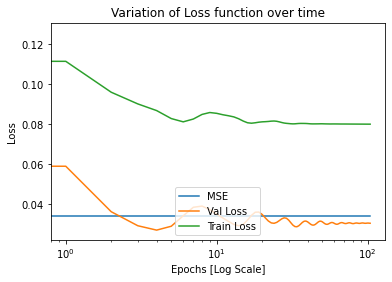

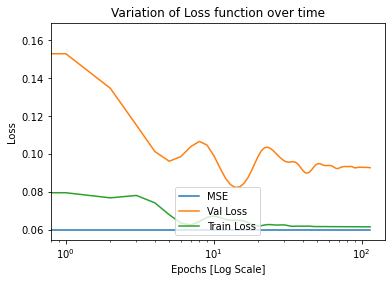

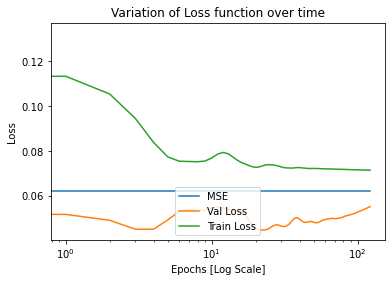

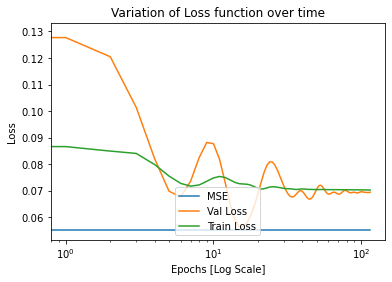

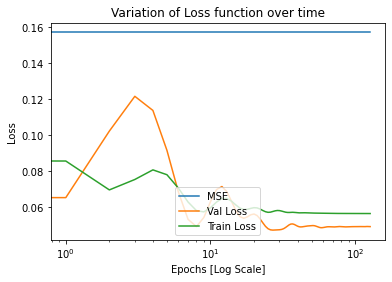

Average Time Taken: 2.8654266 seconds
Average MSE: 0.07365824439688465, Min MSE: 0.03414846486368388, Max MSE: 0.15723851312561177
checking weekday
Average Time Taken: 0.0017205999999999999 seconds
Average MSE: 0.04285525137890517, Min MSE: 0.005431289937344029, Max MSE: 0.12617040651558348


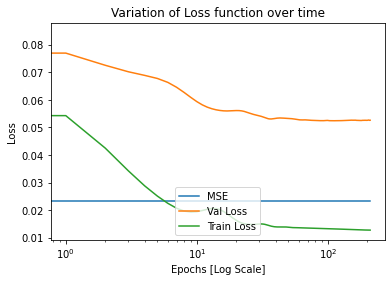

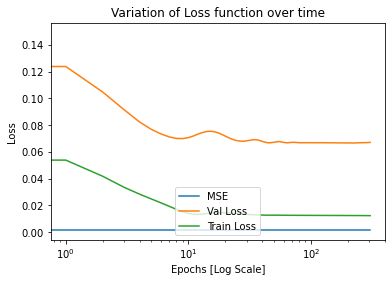

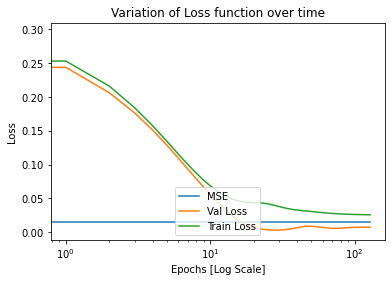

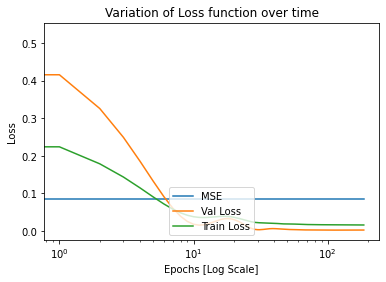

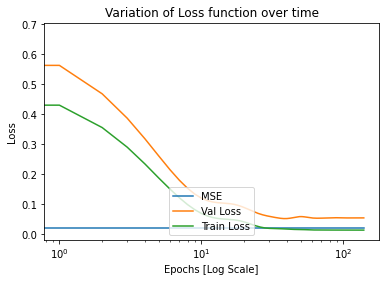

Average Time Taken: 4.0869312 seconds
Average MSE: 0.02939652826916985, Min MSE: 0.0015061863071290879, Max MSE: 0.08501536256084574
checking hour
Average Time Taken: 0.001671 seconds
Average MSE: 0.053334741659028476, Min MSE: 0.009094492684650027, Max MSE: 0.10456054289641914


In [ ]:
data_size = 100
input_dir = "s3://cloud-project-x"
output_dir = "s3://cloud-project-x/output"
main_function(data_size, input_dir, output_dir)
